# Conditional WGAN - Generate Image for Specific Digits


I altered the generator network to take the prior noise appended with the one-hot encoding of a digit instead of just the prior noise. I also added the one-hot encoding of the digit to the discriminator (critic) network, but I added it after the convolution layers so that it doesn't interfere with extracting 2d features.


Then I tried to find a good loss function.



[1,2] implemented conditional GAN and conditional WGAN respectively. Both paper used the same loss function as a non-conditional GAN/WGAN. However, when I tried to use the same loss function, both the generator and the discriminator just ignored the label input and generated images not related to the labels. I am trying to reproduce their results and understand why their methods work.


Intuitively, I thought that the network should be trained not only on pairs of real and fake data, but also pairs of data with correct and wrong labels. However, just adding $\mathbf{E}_{(x, y)\sim P_{(x, wrong\ label)}}\big[D_{\theta_d}(x, y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big]$ to the original WGAN loss $\mathbf{E}_{(z, y)\sim \Pi(P_{z}, P_{label})}\big[D_{\theta_d}(G_{\theta_g}(z), y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big] + \lambda\big(\Vert\nabla_{\hat{x}}D_{\theta_d}(\hat{x}, y)\Vert_2-1\big)^2$ has no effect on the training, as the discriminator will just give the same scores to images that are matched to correct and wrong labels. The reason is that the discriminator can "cheat" by assigning high scores to real images regardless of the label, and making the added term zero without having to distinguish whether the labels are correct or not.


Then, I realized that each of the two terms above defines a different loss surface, and the optimal discriminator I want to get should be near the global minimum that both shared. I tried the idea of alternating the training of the discriminator with respect to the first and then the second loss term for each batch, and attained good results (see below). Interestingly, it seems that better results are obtained if I slow down the training with respect to the loss on correct vs wrong labels. Later I read about multi-task learning [3] and think that this can be classified as an instance of multi-task learning.


There are questions that I could explore further:
1. adjsut the magnitude of the one-hot encoding (instead of [0, 0, 1, 0, ... 0], have [0, 0, 1000, 0, ..., 0]). Intuitively this will make the distance between the correct data $P_{(image,\ correct\ label)}$ far away from the wrong data $P_{(image,\ wrong\ label)}$.
1. Generating from random distributions that have 10 modes instead of one. In non-conditional WGAN, it seemed that 1, 4, 7 and 9 are generated much more often than other numbers (mode collapse?), so it might help to have multiple modes from the start
1. Is it better to use real images with wrong labels or fake images with wrong labels?
1. Would it make a difference if noises are added to the one-hot encoded labels?
1. What's the optimal learning plan? Is there a better loss for discriminating correct labels from wrong labels?


[1] Mehdi Mirza and Simon Osindero, Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784 (2014).

[2] Cameron Fabbri, Conditional Wasserstein Generative Adversarial Networks. (2017)

[3] Sebastian Ruder, An Overview of Multi-Task Learning in Deep Neural Networks. arXiv:1706.05098 (2017)

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug
import tensorflow.contrib as tc
import tensorflow.contrib.layers as tcl
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

%matplotlib inline

/home/rluo/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def leaky_relu(x, alpha=0.1):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

In [3]:
def gen_net(z, digit, hidden_dims, out_dim):
    with tf.variable_scope('gen', reuse=tf.AUTO_REUSE) as vs:
        fc = tf.concat([z, digit], axis=1)
        for dim in hidden_dims:
            fc = tcl.fully_connected(
                    fc, dim,
                    weights_initializer=tf.random_normal_initializer(stddev=0.1),
                    weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                    activation_fn=tcl.batch_norm
            )
            fc = leaky_relu(fc)
        fc = tcl.fully_connected(
            fc, out_dim,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
            activation_fn=tf.sigmoid
        )
        
        return fc

In [4]:
def crit_net(x, digits):
    with tf.variable_scope('critic', reuse=tf.AUTO_REUSE) as vs:
        bs = tf.shape(x)[0]
        x = tf.reshape(x, [bs, 28, 28, 1])
        conv1 = tc.layers.convolution2d(
            x, 256, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        conv1 = leaky_relu(conv1)
        # conv1 = tcl.max_pool2d(conv1, [2, 2])
        conv2 = tc.layers.convolution2d(
            conv1, 128, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        conv2 = leaky_relu(conv2)
        # conv2 = tcl.max_pool2d(conv2, [2, 2])
        conv2 = tcl.flatten(conv2)
        fc1 = tc.layers.fully_connected(
            tf.concat([conv2, digits], axis = 1), 128,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        fc1 = tf.nn.dropout(leaky_relu(tc.layers.layer_norm(fc1)), 0.95)
        fc2 = tc.layers.fully_connected(
            fc1, 64,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        fc2 = tf.nn.dropout(leaky_relu(tc.layers.layer_norm(fc2)), 0.95)
        fc3 = tc.layers.fully_connected(
            fc2, 16,
            weights_initializer=tf.random_normal_initializer(stddev=0.1),
            activation_fn=tcl.layer_norm
        )
        fc3 = leaky_relu(fc3)
        fc3 = tc.layers.fully_connected(fc3, 1, activation_fn=tf.sigmoid)
        
        return fc3

In [5]:
z_dim = 100
gen_hidden_dims = [256, 512, 512, 512]

batch_size = 275

with tf.device('/device:GPU:0'):


    ## Place holder for the real images
    x_correct = tf.placeholder(tf.float32, [batch_size, 28 * 28], name='x_correct')
    x_correct_digit = tf.placeholder(tf.float32, [batch_size, 10], name='x_correct_digit')
    x_wrong = tf.placeholder(tf.float32, [batch_size, 28 * 28], name='x_wrong')
    x_wrong_digit = tf.placeholder(tf.float32, [batch_size, 10], name='x_wrong_digit')
    ## Place holder for the noise
    z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z')
    z_out = gen_net(z, x_correct_digit, gen_hidden_dims, 28 * 28)
    # Define the ops and weights for Discriminator
    y_correct_data = crit_net(x_correct, x_correct_digit)
    y_wrong_data = crit_net(x_wrong, x_wrong_digit)
    y_fake = crit_net(z_out, x_correct_digit)

    eps = tf.random_uniform([batch_size, 1])
    x_hat = eps * x_correct + (1 - eps) * z_out
    y_mid = crit_net(x_hat, x_correct_digit)

    lam = 10
    gradients = tf.gradients(y_mid, x_hat)[0]
    crit_loss1 = (tf.reduce_mean(y_fake)
                 - tf.reduce_mean(y_correct_data)
                 + lam * tf.reduce_mean(tf.square(tf.norm(gradients, axis=1) - 1))
                )
    crit_loss2 = (tf.reduce_mean(y_wrong_data)
                 - tf.reduce_mean(y_correct_data)
                )

    gen_loss = -tf.reduce_mean(y_fake)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        c_adam1 = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.95)\
            .minimize(crit_loss1, var_list=[var for var in tf.global_variables() if 'crit' in var.name])
        c_adam2 = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.95)\
            .minimize(crit_loss2, var_list=[var for var in tf.global_variables() if 'crit' in var.name])
        g_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.95)\
            .minimize(gen_loss, var_list=[var for var in tf.global_variables() if 'gen' in var.name])
    
    init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=None)

Discriminator Loss 1:

$\mathbf{E}_{(z, y)\sim \Pi(P_{z}, P_{label})}\big[D_{\theta_d}(G_{\theta_g}(z), y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big] + \lambda\big(\Vert\nabla_{\hat{x}}D_{\theta_d}(\hat{x}, y)\Vert_2-1\big)^2$

- Approximation to Wasserstein distance between $P_{(G_{\theta_g}(z), y)}, z\sim P_{z}$ and $P_{(x, correct\ label)}$

Discriminator Loss 2:

$\mathbf{E}_{(x, y)\sim P_{(x, wrong\ label)}}\big[D_{\theta_d}(x, y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big]$

- requires the discriminator to give high scores to real image with correct label and low scores to real image with wrong label

In [6]:
def try_models(save_name, epochs, use_loss2=False, early_stop_loss2=False):
    # Read (reset epochs) the MNIST datadet
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    costc1 = []
    costc2 = []
    costg = []
    pcorrect_list = []
    pwrong_list = []
    pfake_list = []
    gpu_options = tf.GPUOptions(allow_growth=False)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(init)

        epoch = 0
        while mnist.train.epochs_completed <= epochs:
            for _ in range(5):

                x_correct_sample, x_correct_label = mnist.train.next_batch(batch_size)
                x_wrong_sample, x_wrong_original_label = mnist.test.next_batch(batch_size)

                x_wrong_label = np.zeros((batch_size, 10))
                x_wrong_original_digits = np.argmax(x_wrong_original_label, axis=1)
                for j in range(batch_size):
                    wrong_digit = np.random.choice([k for k in range(10) if not k == x_wrong_original_digits[j]])
                    x_wrong_label[j][wrong_digit] = 1

                z_in = np.random.uniform(0.0, 1.0, size=(batch_size, z_dim)).astype(np.float32)

                sess.run(c_adam1, feed_dict={
                    x_correct: x_correct_sample,
                    x_correct_digit: x_correct_label,
                    x_wrong: x_wrong_sample,
                    x_wrong_digit: x_wrong_label,
                    z: z_in})

                if use_loss2:
                    if (not early_stop_loss2) or (mnist.train.epochs_completed <= 50):

                        sess.run(c_adam2, feed_dict={
                            x_correct: x_correct_sample,
                            x_correct_digit: x_correct_label,
                            x_wrong: x_wrong_sample,
                            x_wrong_digit: x_wrong_label,
                            z: z_in})

            if use_loss2:
                if early_stop_loss2 and (mnist.train.epochs_completed > 50):

                    sess.run(c_adam2, feed_dict={
                        x_correct: x_correct_sample,
                        x_correct_digit: x_correct_label,
                        x_wrong: x_wrong_sample,
                        x_wrong_digit: x_wrong_label,
                        z: z_in})

            sess.run(g_adam, feed_dict={
                    x_correct: x_correct_sample,
                    x_correct_digit: x_correct_label,
                    x_wrong: x_wrong_sample,
                    x_wrong_digit: x_wrong_label,
                    z: z_in})


            if (mnist.train.epochs_completed > epoch) and (epoch % 10 == 0):
                z_sample = np.random.uniform(0.0, 1.0, size=(batch_size, z_dim)).astype(np.float32)

                digit_sample_one_hot = np.zeros((batch_size, 10))
                for j in range(100):
                    digit_sample_one_hot[j][j % 10] = 1
                out_val_img = sess.run(z_out, feed_dict={z: z_sample, x_correct_digit: digit_sample_one_hot})
                f, a = plt.subplots(10, 10, figsize = (8, 8))
                for i in range(10):
                    for j in range(10):
                        a[j, i].imshow(np.reshape(out_val_img[i * 10 + j], (28, 28)), cmap='gray')
                plt.show()
                

                x_correct_sample, x_correct_label = mnist.test.next_batch(batch_size)
                x_wrong_sample, x_wrong_original_label = mnist.test.next_batch(batch_size)
                x_wrong_label = np.zeros((batch_size, 10))
                x_wrong_original_digits = np.argmax(x_wrong_original_label, axis=1)
                for j in range(batch_size):
                    wrong_digit = np.random.choice([k for k in range(10) if not k == x_wrong_original_digits[j]])
                    x_wrong_label[j][wrong_digit] = 1
                    
                z_in = np.random.uniform(0.0, 1.0, size=(batch_size, z_dim)).astype(np.float32)
                    
                c1, c2, g1 = sess.run([crit_loss1, crit_loss2, gen_loss], feed_dict={
                    x_correct: x_correct_sample,
                    x_correct_digit: x_correct_label,
                    x_wrong: x_wrong_sample,
                    x_wrong_digit: x_wrong_label,
                    z: z_in})
                costc1.append(c1)
                costc2.append(c2)
                costg.append(g1)
                pcorrect, pwrong, pfake = sess.run([tf.reduce_mean(y_correct_data), 
                                                    tf.reduce_mean(y_wrong_data), 
                                                    tf.reduce_mean(y_fake)],
                                                   feed_dict={
                                                       x_correct: x_correct_sample,
                                                       x_correct_digit: x_correct_label,
                                                       x_wrong: x_wrong_sample,
                                                       x_wrong_digit: x_wrong_label,
                                                       z: z_in})
                pcorrect_list.append(pcorrect)
                pwrong_list.append(pwrong)
                pfake_list.append(pfake)
                
                saver.save(sess, f'cwgan/{save_name}_epoch{epoch}.chkp')

            epoch = mnist.train.epochs_completed
            
    return costc1, costc2, costg, pcorrect_list, pwrong_list, pfake_list


In [18]:
def plot_training(c1, c2, g, pc, pw, pf):

    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(c1)
    plt.title('Wasserstein Loss for Critic')

    plt.subplot(222)
    plt.plot(np.array(c2))
    plt.title('Loss 2 for Critic')

    plt.subplot(223)
    plt.plot(g)
    plt.title('Generator Loss')

    plt.subplot(224)
    plt.plot(pc, label='real with correct labels')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.plot(pw, label='real with wrong labels')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.plot(pf, label='fake')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Critic Scores')

    plt.subplots_adjust(left=0.2, wspace=0.5, top=0.8, hspace=0.5)
    plt.show()

# trained with Wasserstein loss only

From the results we can see that the generator failed to capture the relationship between the input label and the output image, and the discriminator/critic failed to realize that either. Judging by the trend of loss 2, maybe it needs many more epochs for the critic to capture the relationship between the image and the label.

In [ ]:
costc11, costc21, costg1, pcorrect_list1, pwrong_list1, pfake_list1 = (
    try_models(save_name='wgan_loss_only', epochs=150, use_loss2=False, early_stop_loss2=False)
)

INFO:tensorflow:Restoring parameters from cwgan/wgan_loss_only_epoch150.chkp


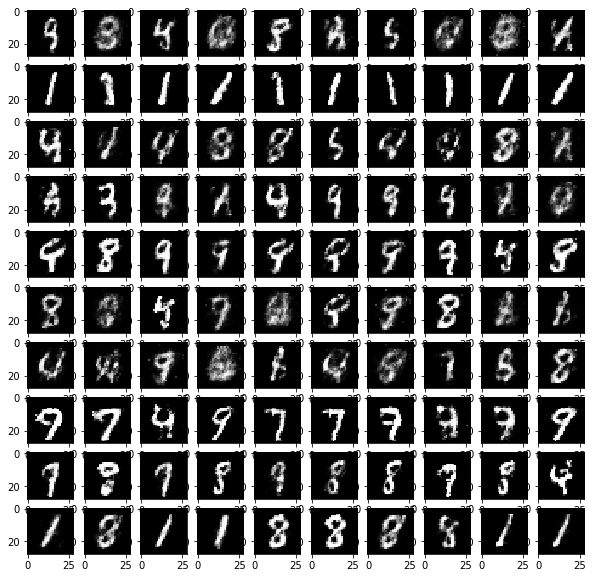

In [17]:
with tf.Session() as sess:
    saver.restore(sess, 'cwgan/wgan_loss_only_epoch150.chkp')
    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
    digit_sample_one_hot = np.zeros((batch_size, 10))
    for j in range(100):
        digit_sample_one_hot[j][j % 10] = 1
    out_val_img = sess.run(z_out, feed_dict={z: z_sample, x_correct_digit: digit_sample_one_hot})
    f, a = plt.subplots(10, 10, figsize = (10, 10))
    for i in range(10):
        for j in range(10):
            a[j, i].imshow(np.reshape(out_val_img[i * 10 + j], (28, 28)), cmap='gray')
    plt.show()

Note: 

Each point represent the result after additional 10 epochs

$Wasserstein\ Loss = \mathbf{E}_{(z, y)\sim \Pi(P_{z}, P_{label})}\big[D_{\theta_d}(G_{\theta_g}(z), y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big] + \lambda\big(\Vert\nabla_{\hat{x}}D_{\theta_d}(\hat{x}, y)\Vert_2-1\big)^2$

$Total\ Loss = Wasserstein\ Loss + \Big(\mathbf{E}_{(x, y)\sim P_{(x, wrong\ label)}}\big[D_{\theta_d}(x, y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big]\Big)$

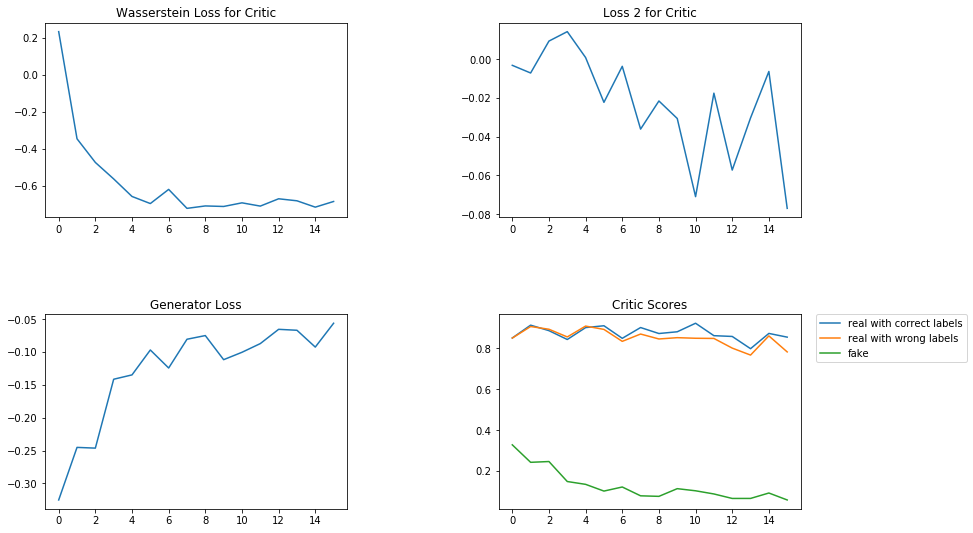

In [19]:
plot_training(costc11, costc21, costg1, pcorrect_list1, pwrong_list1, pfake_list1)

# trained with alternating losses

Alternating the losses throughout the training seemed to have led the critic focus on discriminating correct labels against wrong labels. It might be the case that the learning rate on the loss that compares images with correct labels against wrong labels is too high (i.e. the loss curve from loss 2 could be steeper than the Wasserstien loss (loss 1), and hence driving the parameters away from actually optimizing the Wasserstein loss)

In [ ]:
costc13, costc23, costg3, pcorrect_list3, pwrong_list3, pfake_list3 = (
    try_models(save_name='wgan_alternating_loss', epochs=150, use_loss2=True, early_stop_loss2=False)
)

INFO:tensorflow:Restoring parameters from cwgan/wgan_alternating_loss_epoch150.chkp


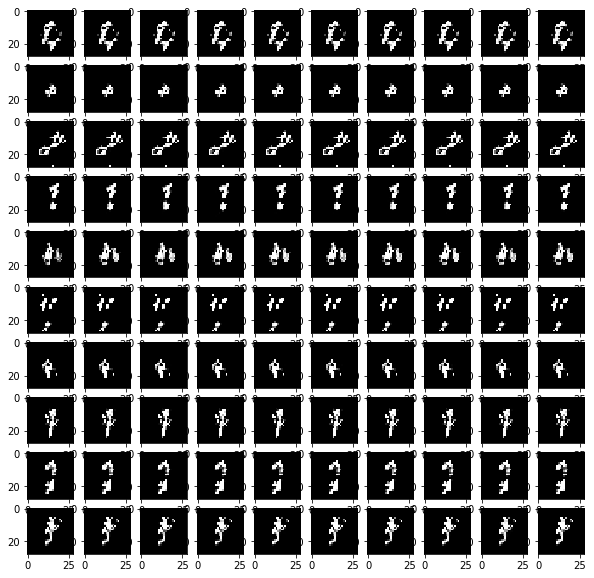

In [15]:
with tf.Session() as sess:
    saver.restore(sess, 'cwgan/wgan_alternating_loss_epoch150.chkp')
    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
    digit_sample_one_hot = np.zeros((batch_size, 10))
    for j in range(100):
        digit_sample_one_hot[j][j % 10] = 1
    out_val_img = sess.run(z_out, feed_dict={z: z_sample, x_correct_digit: digit_sample_one_hot})
    f, a = plt.subplots(10, 10, figsize = (10, 10))
    for i in range(10):
        for j in range(10):
            a[j, i].imshow(np.reshape(out_val_img[i * 10 + j], (28, 28)), cmap='gray')
    plt.show()

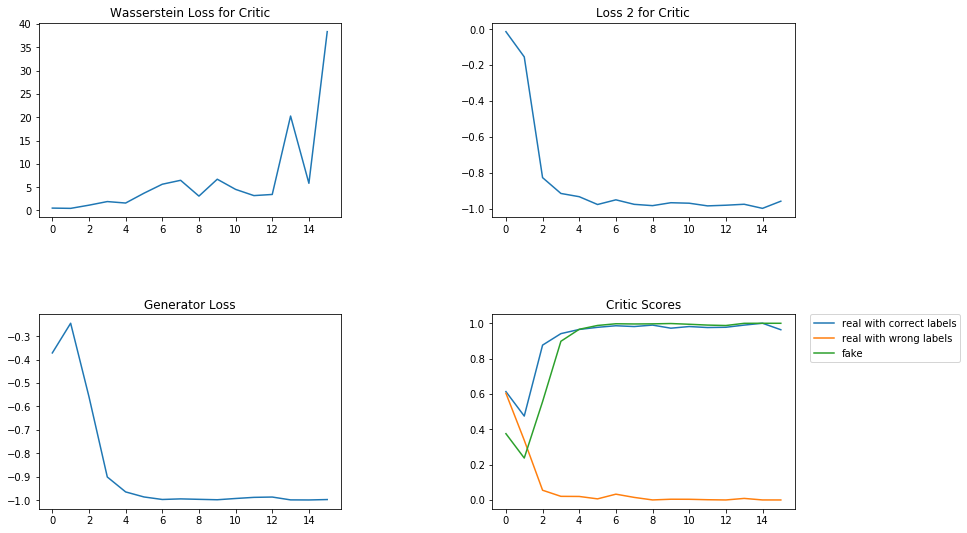

In [20]:
plot_training(costc13, costc23, costg3, pcorrect_list3, pwrong_list3, pfake_list3)

# trained with alternating losses and slow down the training on 2nd loss midway

It seems that by firstly training with both losses drove the generator near the subspace that corresponds to the correct image-label pairs. Then by slowing down the training on the second loss (trained once per 5 iterations of training with Wasserstien loss), the generator could focus on getting more realistic images without shuffling them into spaces corresponding to other labels. We can see that this method allows both networks to learn much faster than the first method.

In [ ]:
costc12, costc22, costg2, pcorrect_list2, pwrong_list2, pfake_list2 = (
    try_models(save_name='wgan_alternating_early_stop', epochs=150, use_loss2=True, early_stop_loss2=True)
)

INFO:tensorflow:Restoring parameters from cwgan/wgan_alternating_early_stop_epoch150.chkp


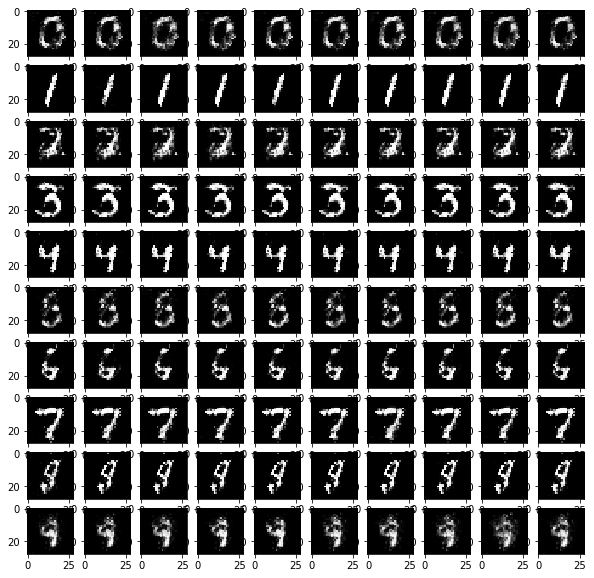

In [16]:
with tf.Session() as sess:
    saver.restore(sess, 'cwgan/wgan_alternating_early_stop_epoch150.chkp')
    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
    digit_sample_one_hot = np.zeros((batch_size, 10))
    for j in range(100):
        digit_sample_one_hot[j][j % 10] = 1
    out_val_img = sess.run(z_out, feed_dict={z: z_sample, x_correct_digit: digit_sample_one_hot})
    f, a = plt.subplots(10, 10, figsize = (10, 10))
    for i in range(10):
        for j in range(10):
            a[j, i].imshow(np.reshape(out_val_img[i * 10 + j], (28, 28)), cmap='gray')
    plt.show()

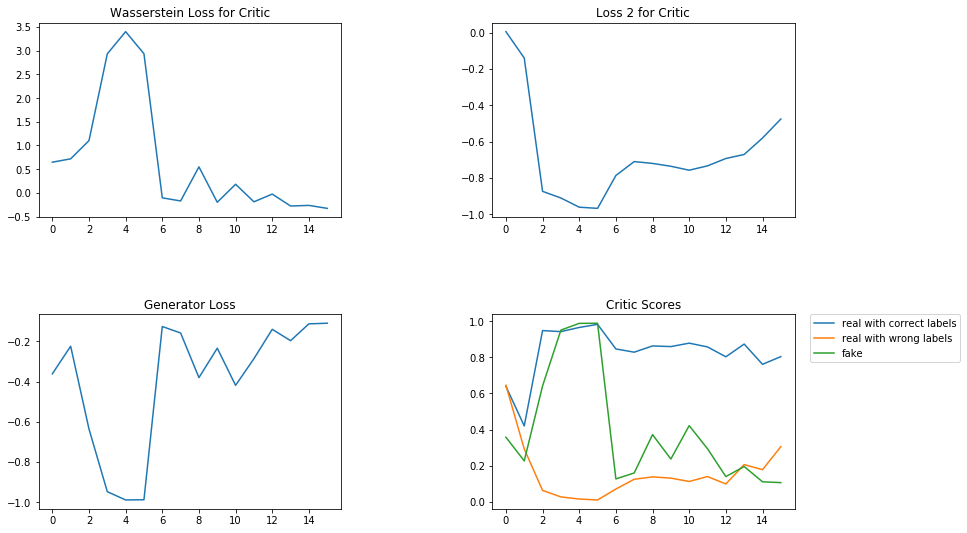

In [21]:
plot_training(costc12, costc22, costg2, pcorrect_list2, pwrong_list2, pfake_list2)